# ⚡ Proyecto: Predicción de Demanda Energética (PJM Hourly)
**Autor:** Luis Mauricio Aguirre Stornaiuolo (Economía - UNMSM)

---

## 🎯 Objetivo
Desarrollar un modelo predictivo capaz de estimar el consumo de energía eléctrica (en MW) a nivel horario. Se busca contrastar la eficacia de los enfoques econométricos tradicionales frente a algoritmos modernos de Machine Learning.

## 🧠 Enfoques Comparados
1.  **Enfoque Econométrico (Statsmodels):**
    * Análisis de Estacionariedad (Dickey-Fuller) y Autocorrelación.
    * Modelado **ARIMA** (AutoRegressive Integrated Moving Average).
    * Modelado **SARIMA** (Seasonal ARIMA) para capturar ciclos diarios.
2.  **Enfoque Machine Learning (XGBoost):**
    * Ingeniería de Características (Creación de variables de calendario).
    * Entrenamiento supervisado con Gradient Boosting.

## 📊 Dataset
* **Fuente:** PJM Interconnection LLC (Kaggle).
* **Serie:** `PJME_hourly` (PJM East Region).
* **Periodo:** 2002 - 2018 (Datos horarios).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
ruta = "https://raw.githubusercontent.com/MrPinkiePie/energy-consumption-forecasting/refs/heads/main/PJME_hourly.csv"
data = pd.read_csv(ruta)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [4]:
data["Datetime"] = pd.to_datetime(data["Datetime"])

In [5]:
data.set_index("Datetime", inplace=True)

In [6]:
data = data.sort_index()

In [7]:
print(f"Hay un total de {data.index.duplicated().sum()} valores duplicados")
data = data[~data.index.duplicated(keep="first")]
print(f"Ahora hay un total de {data.index.duplicated().sum()} valores duplicados")

Hay un total de 4 valores duplicados
Ahora hay un total de 0 valores duplicados


<Axes: xlabel='Datetime'>

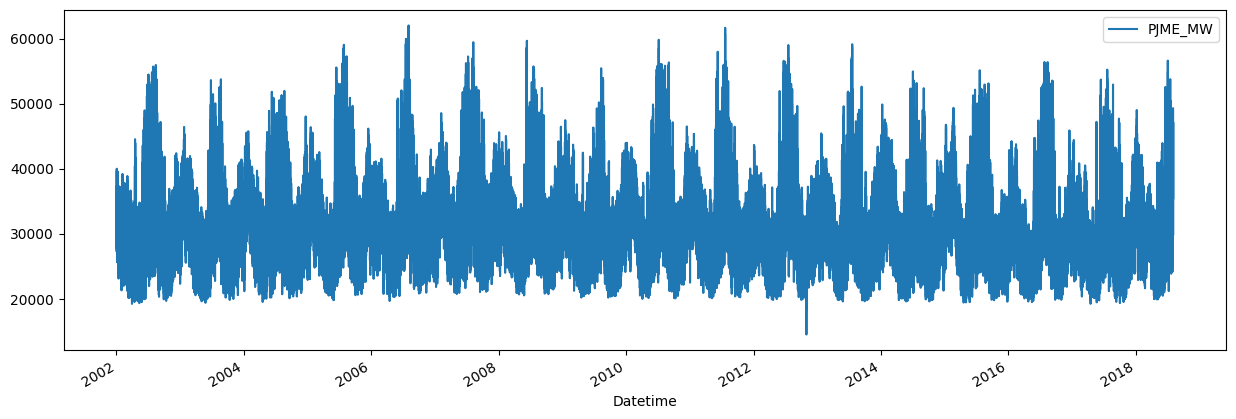

In [8]:
data.plot(kind="line",figsize=(15,5))

/tmp/ipython-input-3522477819.py:5: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  data_anual = data['PJME_MW'].resample("Y").mean()


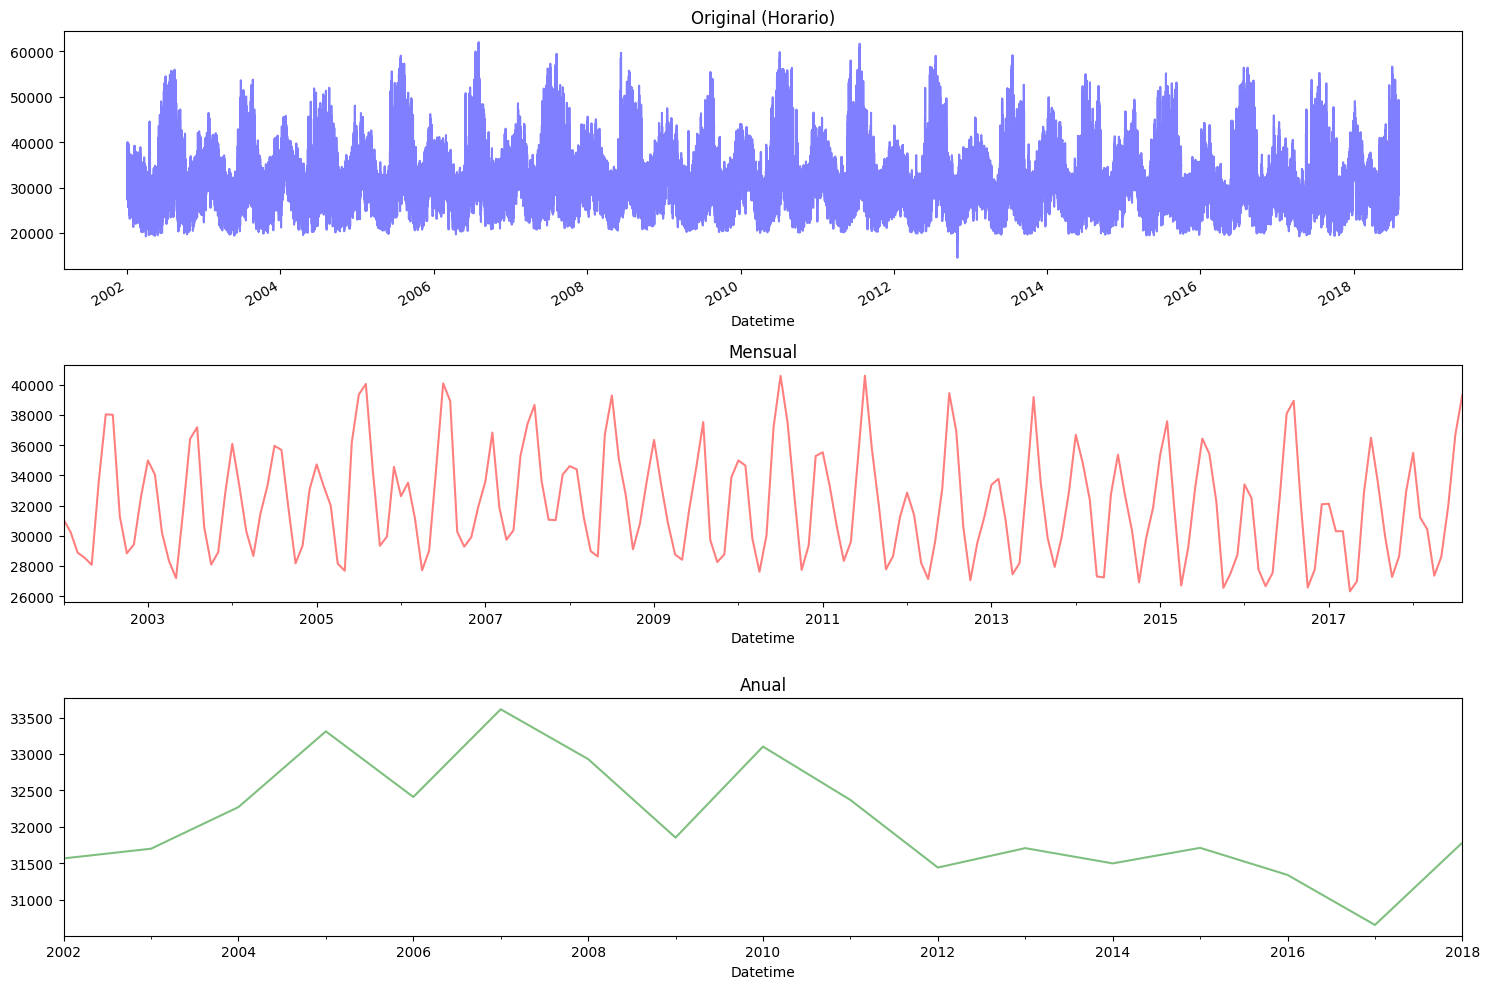

In [9]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(15,10),sharex=False)
data['PJME_MW'].plot(ax=ax1, title='Original (Horario)', color='blue', alpha=0.5)
data_mensual = data['PJME_MW'].resample("ME").mean()
data_mensual.plot(ax=ax2, title='Mensual', color='red', alpha=0.5)
data_anual = data['PJME_MW'].resample("Y").mean()
data_anual.plot(ax=ax3, title='Anual', color='green', alpha=0.5)

plt.tight_layout()
plt.show()

#Revisión de estadísticos del modelo

### Test de Raíz Unitaria

In [10]:
from statsmodels.tsa.stattools import adfuller

In [11]:
adf = adfuller(data["PJME_MW"],autolag="AIC")
print(f'ADF Statistic: {adf[0]}')
print(f'p-value: {adf[1]}')

if adf[1] <= 0.05:
    print('La serie es estacionaria')
else:
    print('La serie no es estacionaria')

ADF Statistic: -19.885450432224996
p-value: 0.0
La serie es estacionaria


### Gráficos ACF y PACF

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

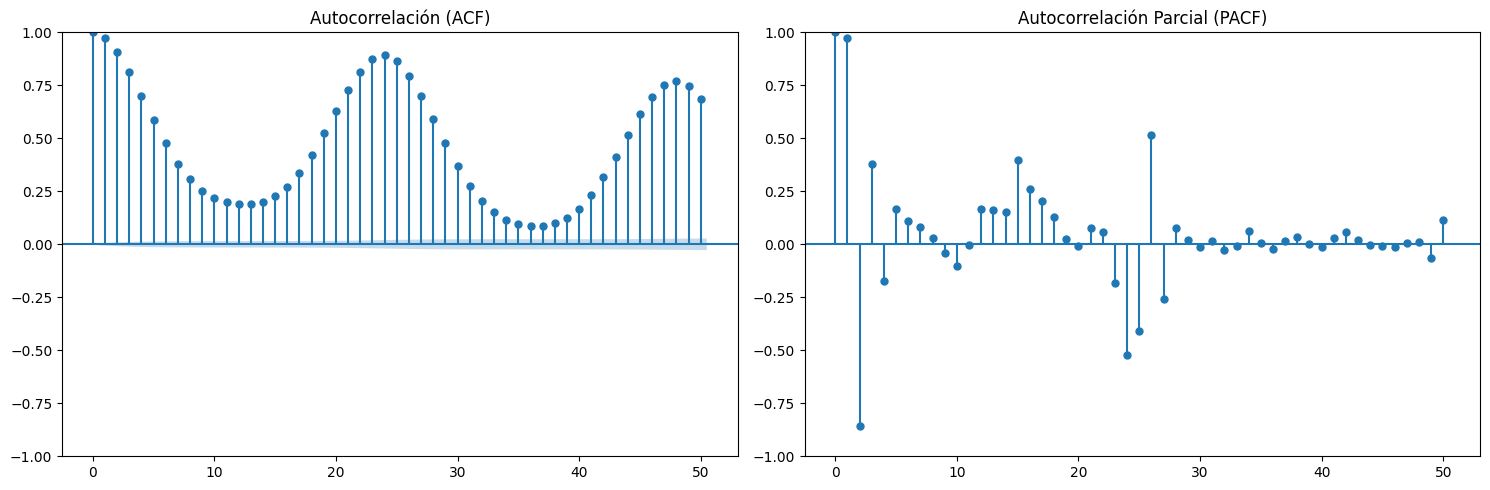

In [13]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
plot_acf(data["PJME_MW"],lags=50,ax=ax1,title="Autocorrelación (ACF)")
plot_pacf(data["PJME_MW"],lags=50,ax=ax2,title="Autocorrelación Parcial (PACF)")
plt.tight_layout()
plt.show()

### Test de normalidad de Jarque-Bera

In [14]:
from scipy.stats import jarque_bera

In [15]:
jb_statistic,p_value = jarque_bera(data["PJME_MW"])

In [16]:
print(f"JB Statistic: {jb_statistic}")
print(f"p-value: {p_value}")

JB Statistic: 16521.16481384993
p-value: 0.0


### Test autocorrelación Ljung-Box

In [17]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [18]:
ljung_test = acorr_ljungbox(data['PJME_MW'],lags=[24, 48],return_df=True)
print("\n--- Test Ljung-Box ---")
print(ljung_test)


--- Test Ljung-Box ---
         lb_stat  lb_pvalue
24  1.138780e+06        0.0
48  1.929715e+06        0.0


In [19]:
p_val_24 = ljung_test.loc[24, 'lb_pvalue']
p_val_48 = ljung_test.loc[48, 'lb_pvalue']
if p_val_24 > 0.05 and p_val_48 > 0.05:
    print("No hay autocorrelación significativa")
else:
    print("Hay autocorrelación significativa")

Hay autocorrelación significativa


## Desarrollo de los modelos econométricos

### División de los datos

In [20]:
split_date = "2017-01-01"

In [21]:
train = data.loc[data.index < split_date]
test = data.loc[data.index >= split_date]

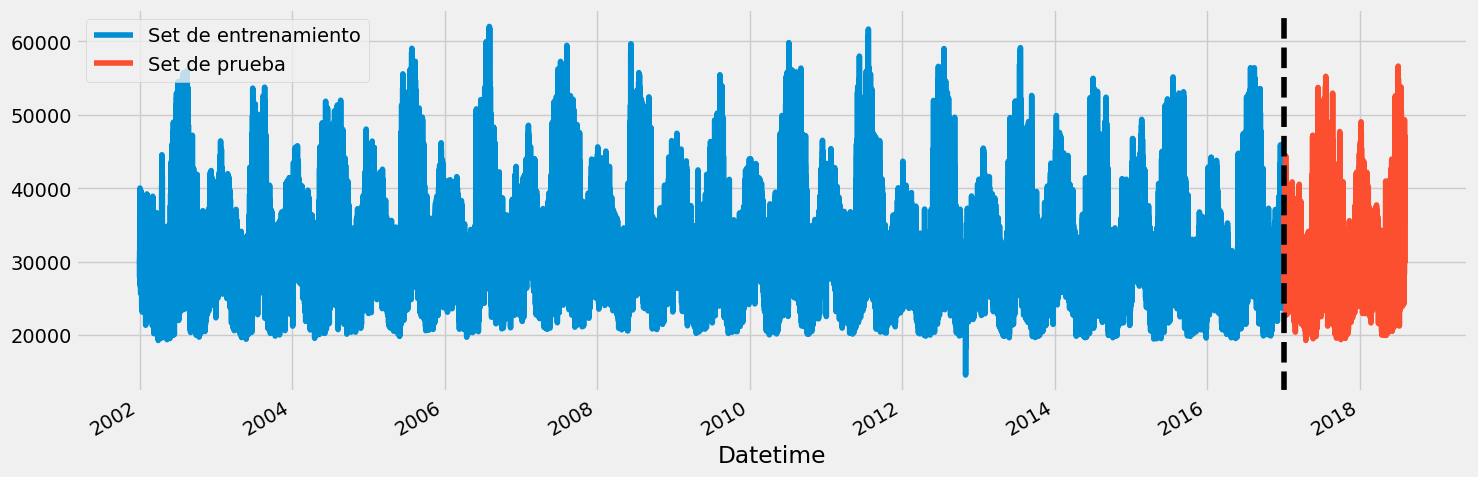

In [22]:
plt.style.use('fivethirtyeight')
fig,ax = plt.subplots(figsize=(15,5))
train['PJME_MW'].plot(ax=ax,label='Set de entrenamiento')
test['PJME_MW'].plot(ax=ax,label='Set de prueba')
ax.axvline(split_date, color='black', ls='--')
plt.tight_layout()
plt.legend()
plt.show()

### Modelo ARIMA

In [23]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [24]:
modelo = ARIMA(train['PJME_MW'], order=(4, 1, 0))

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [25]:
modelo_fit = modelo.fit()

In [26]:
print(modelo_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                PJME_MW   No. Observations:               131467
Model:                 ARIMA(4, 1, 0)   Log Likelihood            -1048035.142
Date:                Sun, 25 Jan 2026   AIC                        2096080.285
Time:                        21:13:49   BIC                        2096129.217
Sample:                             0   HQIC                       2096094.954
                             - 131467                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2833      0.002    724.670      0.000       1.280       1.287
ar.L2         -0.7194      0.003   -277.893      0.000      -0.725      -0.714
ar.L3          0.3935      0.003    121.343      0.0

### Forecasting del modelo ARIMA(4,1,0)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


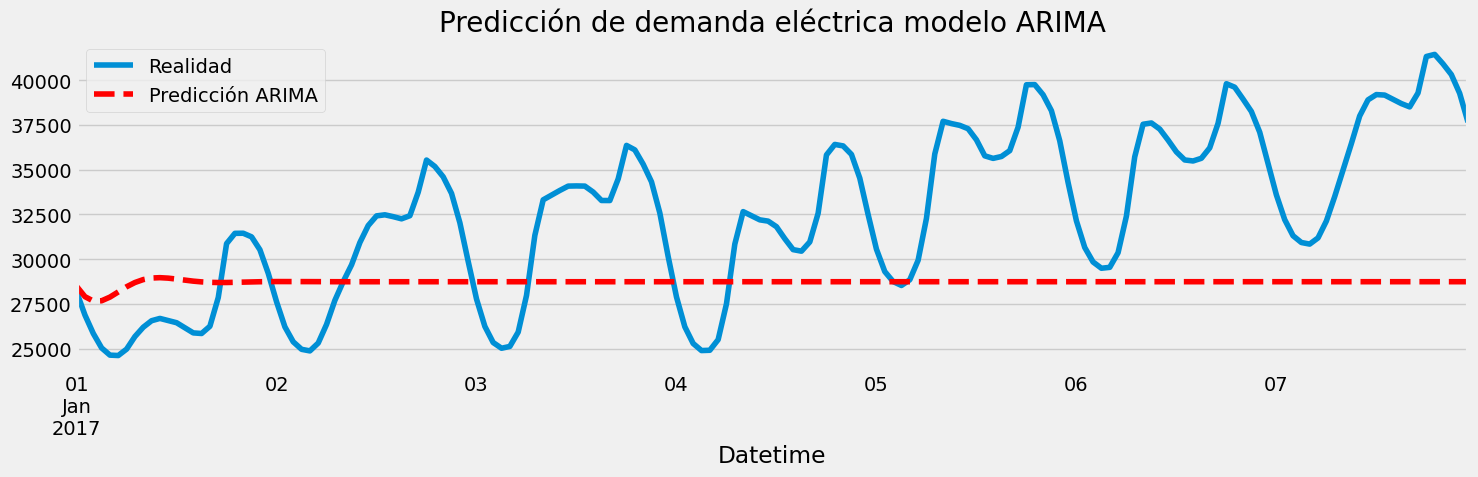

RMSE (Error Cuadrático Medio) del ARIMA: 6552.08 MW


In [27]:
start = len(train)
end = len(train) + len(test) - 1

forecast = modelo_fit.predict(start=start, end=end, typ='levels',dynamic=False)
forecast.index = test.index

plt.figure(figsize=(15,5))
plt.title("Predicción de demanda eléctrica modelo ARIMA")
test['PJME_MW'].iloc[:168].plot(label='Realidad', legend=True)
forecast.iloc[:168].plot(label='Predicción ARIMA', legend=True, color='red', linestyle='--')
plt.tight_layout()
plt.show()
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['PJME_MW'], forecast))
print(f"RMSE (Error Cuadrático Medio) del ARIMA: {rmse:.2f} MW")

### Modelo SARIMA

In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [29]:
train_small = train.tail(24*60)

In [30]:
modelo_sarima = SARIMAX(train_small['PJME_MW'],
                        order=(1,1,1),
                        seasonal_order=(1,1,1,24))

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


In [31]:
modelo_fit_sarima = modelo_sarima.fit(disp = False)

In [32]:
print(modelo_fit_sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            PJME_MW   No. Observations:                 1440
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -10090.893
Date:                            Sun, 25 Jan 2026   AIC                          20191.786
Time:                                    21:14:30   BIC                          20218.061
Sample:                                11-02-2016   HQIC                         20201.603
                                     - 12-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4726      0.014     33.166      0.000       0.445       0.501
ma.L1          0.4548      0.019   

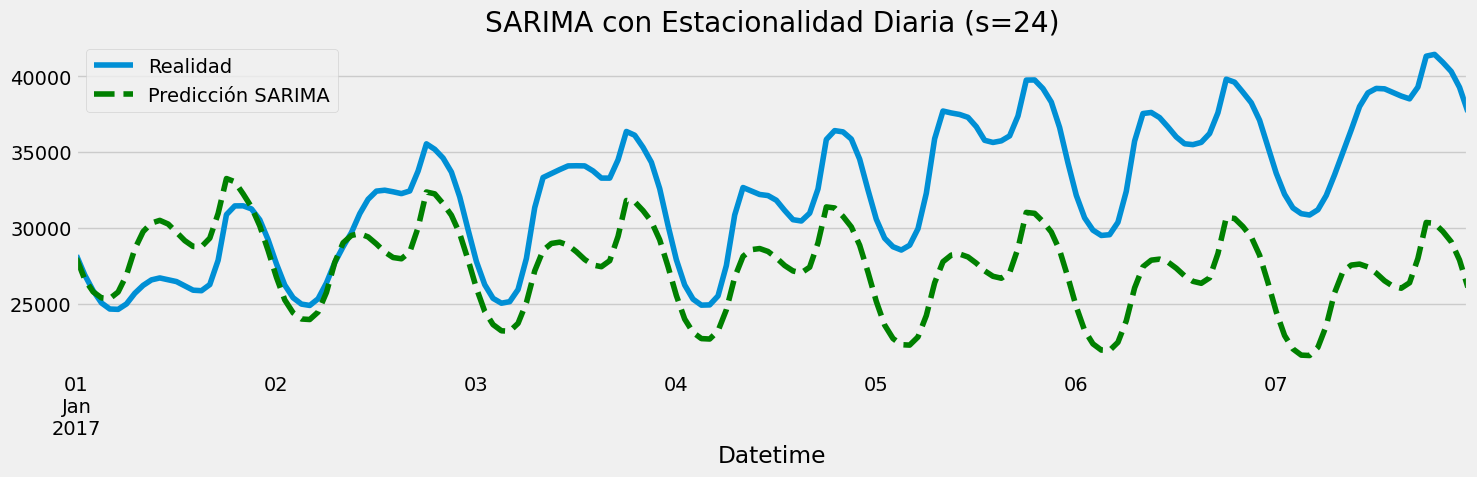

RMSE SARIMA (1 semana): 6583.84 MW


In [33]:
# Predicción sobre el Test Set (las primeras 168 horas / 1 semana)
start = len(train_small)

forecast_sarima = modelo_fit_sarima.get_forecast(steps=168)
prediccion_sarima = forecast_sarima.predicted_mean

# Asignar índice correcto (las primeras 168 horas del test original)
prediccion_sarima.index = test.index[:168]

# Graficar
plt.figure(figsize=(15, 5))
plt.title("SARIMA con Estacionalidad Diaria (s=24)")

# Realidad
test['PJME_MW'].iloc[:168].plot(label='Realidad', legend=True)

# Predicción SARIMA
prediccion_sarima.plot(label='Predicción SARIMA', legend=True, color='green', linestyle='--')

plt.tight_layout()
plt.show()

# Calcular RMSE
rmse_sarima = np.sqrt(mean_squared_error(test['PJME_MW'].iloc[:168], prediccion_sarima))
print(f"RMSE SARIMA (1 semana): {rmse_sarima:.2f} MW")

##Desarrollo del modelo de Machine Learning

In [34]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [35]:
data_ml = data.copy()

In [36]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    return df

In [37]:
data_ml = create_features(data_ml)

In [38]:
data_ml.head(5)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth
Datetime,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1


In [39]:
split_date = "2017-01-01"
train_ml = data_ml.loc[data_ml.index < split_date]
test_ml = data_ml.loc[data_ml.index >= split_date]

In [40]:
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

In [41]:
X_train = train_ml[FEATURES]
y_train = train_ml[TARGET]

X_test = test_ml[FEATURES]
y_test = test_ml[TARGET]

In [42]:
print(f"Dimensiones Train: {X_train.shape}")
print(f"Dimensiones Test: {X_test.shape}")

Dimensiones Train: (131467, 6)
Dimensiones Test: (13895, 6)


In [43]:
modelo_xgb = XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50, # Para si no mejora en 50 intentos
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)

In [44]:
modelo_xgb.fit(X_train,y_train,
               eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32513.61680	validation_1-rmse:31344.73709
[100]	validation_0-rmse:12562.05074	validation_1-rmse:11447.20700
[200]	validation_0-rmse:5855.92467	validation_1-rmse:5142.66631
[300]	validation_0-rmse:3963.20856	validation_1-rmse:3955.77878
[400]	validation_0-rmse:3494.80386	validation_1-rmse:3894.83362
[411]	validation_0-rmse:3470.58735	validation_1-rmse:3896.57121


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [45]:
feature_important = modelo_xgb.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

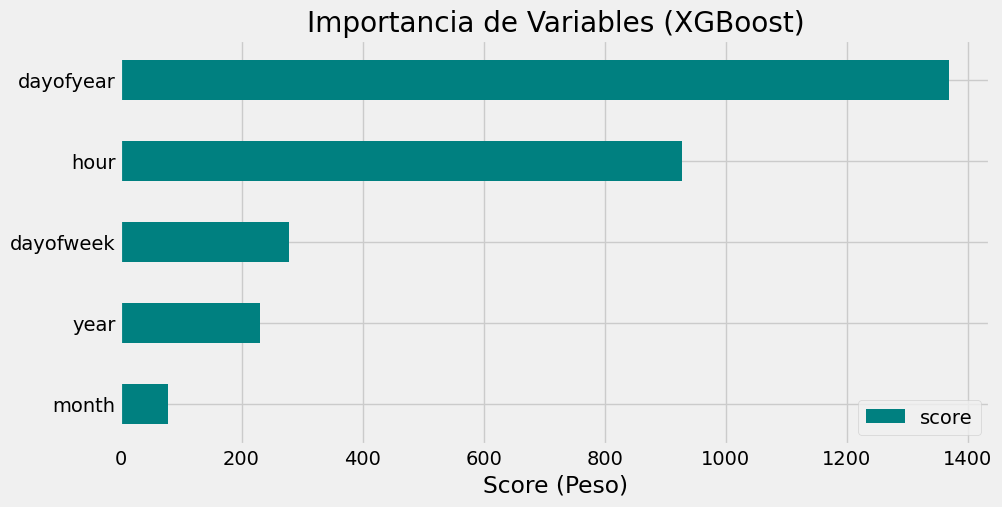

In [46]:
data_imp = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by="score", ascending=True)
data_imp.plot(kind='barh', figsize=(10, 5), title='Importancia de Variables (XGBoost)', color='teal')
plt.xlabel('Score (Peso)')
plt.show()

In [47]:
raw_predictions = modelo_xgb.predict(X_test)

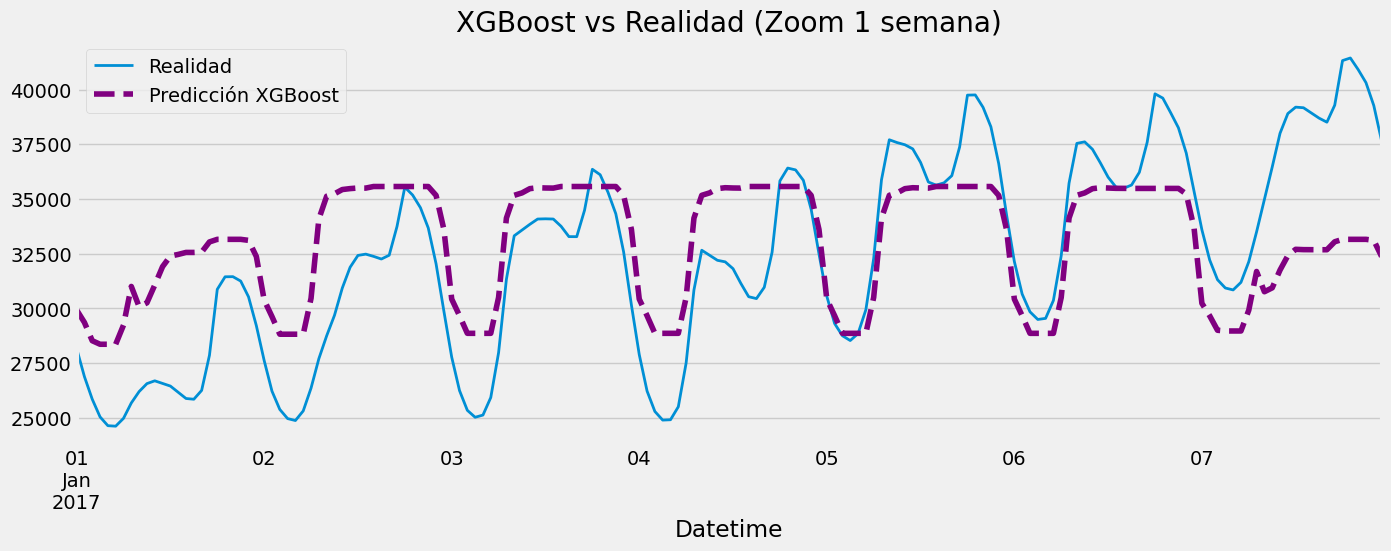

RMSE XGBoost: 3889.32 MW


In [48]:
prediction_xgb = pd.Series(raw_predictions, index=X_test.index)
plt.figure(figsize=(15, 5))
plt.title("XGBoost vs Realidad (Zoom 1 semana)")

# Datos Reales
test_ml['PJME_MW'].iloc[:168].plot(label='Realidad', legend=True, linewidth=2)
# Predicción XGBoost
prediction_xgb.iloc[:168].plot(label='Predicción XGBoost', legend=True, color='purple', linestyle='--')

plt.show()

rmse_xgb = np.sqrt(mean_squared_error(test_ml['PJME_MW'], prediction_xgb))
print(f"RMSE XGBoost: {rmse_xgb:.2f} MW")

# 📊 Conclusiones y Recomendaciones de Negocio

## 1. Resumen Ejecutivo
El objetivo del proyecto fue comparar la eficacia de modelos econométricos clásicos (**ARIMA**) frente a algoritmos de Machine Learning (**XGBoost**) para la predicción de demanda energética horaria.

**El modelo ganador fue XGBoost**, logrando una reducción del error (RMSE) del **41%** respecto a la línea base econométrica.

| Modelo | RMSE (MW) | Performance |
| :--- | :--- | :--- |
| **ARIMA Baseline** | 6,552.08 | 🔴 Bajo desempeño (Reversión a la media) |
| **XGBoost Final** | **3,889.32** | 🟢 Alto desempeño (Captura de patrones complejos) |

---

## 2. Diagnóstico Técnico (Visión Econométrica)

### ¿Por qué falló el enfoque clásico (ARIMA)?
A pesar de que las pruebas de **Dickey-Fuller** confirmaron estacionariedad en media, la serie temporal presentó una estructura de autocorrelación compleja (confirmada por el test **Ljung-Box**) que un modelo ARIMA $(p,d,q)$ estándar no pudo capturar.
* **Limitación Estructural:** El modelo sufrió de "miopía temporal". Al carecer de componentes estacionales robustos, las predicciones convergieron rápidamente a la media, resultando en una línea plana incapaz de seguir la volatilidad diaria.
* **Rigidez:** La implementación de un SARIMA completo $(P,D,Q)_{24}$ demostró ser computacionalmente costosa y poco flexible ante cambios abruptos en los patrones de consumo.

### ¿Por qué triunfó Machine Learning (XGBoost)?
El enfoque supervisado permitió "romper" la linealidad de la serie.
* **Ingeniería de Características:** Al transformar el tiempo en variables explícitas (hora del día, día de la semana, mes), el modelo aprendió no solo la inercia (qué pasó hace 1 hora), sino el contexto (comportamiento cíclico).
* **Captura de Picos:** XGBoost logró identificar correctamente los "dobles picos" diarios de demanda y la reducción de consumo en fines de semana, algo que el modelo lineal suavizó excesivamente.

---

## 3. Impacto de Negocio

La mejora en la precisión del modelo tiene implicaciones directas en la eficiencia operativa de la red eléctrica:

1.  **Reducción de Incertidumbre:** Bajar el error en ~2,800 MW equivale a **evitar la reserva innecesaria de capacidad** de una planta de energía mediana.
2.  **Optimización de Costos:** Una predicción más ajustada permite a las generadoras planificar mejor la compra de combustible y el mantenimiento de unidades, evitando el costoso arranque de plantas "peaker" de último minuto.
3.  **Estabilidad de la Red:** Predecir mejor los picos máximos ayuda a prevenir sobrecargas y apagones, mejorando la confiabilidad del servicio.

---

## 4. Próximos Pasos (Recomendaciones)

Para llevar este modelo a producción, se sugieren las siguientes mejoras:

* **Variables Exógenas (Clima):** Incorporar datos de temperatura y humedad. En economía de la energía, la temperatura es el *driver* fundamental de la demanda (calefacción/aire acondicionado). Esto reduciría aún más el RMSE.
* **Optimización de Hiperparámetros:** Utilizar herramientas como *Optuna* o *GridSearch* para afinar la tasa de aprendizaje y la profundidad de los árboles en XGBoost.
* **Ventanas Deslizantes:** Implementar un re-entrenamiento diario del modelo para que se adapte a cambios de tendencia a largo plazo.